# Neural ODE

This example trains a [Neural ODE](https://arxiv.org/abs/1806.07366) to reproduce a toy dataset of nonlinear oscillators.

This example is available as a Jupyter notebook [here](https://github.com/patrick-kidger/diffrax/blob/main/examples/neural_ode.ipynb).

In [7]:
import time

import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax

from jax.experimental.ode import odeint

We use [Equinox](https://github.com/patrick-kidger/equinox) to build neural networks. We use [Optax](https://github.com/deepmind/optax) for optimisers (Adam etc.)

Recalling that a neural ODE is defined as

$y(t) = y(0) + \int_0^t f_\theta(s, y(s)) ds$,

then here we're now about to define the $f_\theta$ that appears on that right hand side.

In [8]:
class Func(eqx.Module):
    mlp: eqx.nn.MLP

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.mlp = eqx.nn.MLP(
            in_size=data_size,
            out_size=data_size,
            width_size=width_size,
            depth=depth,
            activation=jnn.softplus,
            key=key,
        )

    def __call__(self, t, y, args):
        return self.mlp(y)

Here we wrap up the entire ODE solve into a model.

In [9]:
class NeuralODE(eqx.Module):
    func: Func

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.func = Func(data_size, width_size, depth, key=key)

    def __call__(self, ts, y0):
        solution = diffrax.diffeqsolve(
            diffrax.ODETerm(self.func),
            diffrax.Tsit5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1] - ts[0],
            y0=y0,
            stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            saveat=diffrax.SaveAt(ts=ts),
        )
        return solution.ys

Toy dataset of nonlinear oscillators. Sample paths look like deformed sines and cosines.

In [10]:
def _get_data(ts, *, key):
    y0 = jnp.array([30.,4.])

    def f(t, y, args):
        #[0.54686415 0.02760766 0.84253836 0.02607606]
        return jnp.array([0.54686415 * y[0] - 0.02760766 * y[0] * y[1],-0.84253836 * y[1] + 0.02607606 * y[0] * y[1]])

    solver = diffrax.Tsit5()
    dt0 = 0.1
    saveat = diffrax.SaveAt(ts=ts)
    sol = diffrax.diffeqsolve(
        diffrax.ODETerm(f), solver, ts[0], ts[-1], dt0, y0, saveat=saveat
    )
    ys = sol.ys #jax.random.poisson(lam = sol.ys,key = key)
    return ys


def get_data(dataset_size, *, key):
    ts = jnp.arange(0, 20, 0.1)
    key = jr.split(key, dataset_size)
    ys = jax.vmap(lambda key: _get_data(ts, key=key))(key)
    return ts, ys

In [11]:
def dataloader(arrays, batch_size, *, key):
    dataset_size = arrays[0].shape[0]
    assert all(array.shape[0] == dataset_size for array in arrays)
    indices = jnp.arange(dataset_size)
    while True:
        perm = jr.permutation(key, indices)
        (key,) = jr.split(key, 1)
        start = 0
        end = batch_size
        while end < dataset_size:
            batch_perm = perm[start:end]
            yield tuple(array[batch_perm] for array in arrays)
            start = end
            end = start + batch_size

Main entry point. Try runnning `main()`.

In [12]:
def main(
    dataset_size=2,
    batch_size=1,
    lr_strategy=(3e-3,3e-5,3e-5, 3e-5, 3e-5),
    steps_strategy=(1000, 1000,1000,1000, 5000),
    length_strategy=(0.1,0.25,0.5,0.75, 1.),
    width_size=64,
    depth=2,
    seed=5678,
    plot=True,
    print_every=100,
):
    key = jr.PRNGKey(seed)
    data_key, model_key, loader_key = jr.split(key, 3)

    ts, ys = get_data(dataset_size, key=data_key)

    _, length_size, data_size = ys.shape

    ys_full = ys

    ys = ys[:,:int(length_size//2),:]

    _, length_size, data_size = ys.shape

    model = NeuralODE(data_size, width_size, depth, key=model_key)

    # Training loop like normal.
    #
    # Only thing to notice is that up until step 500 we train on only the first 10% of
    # each time series. This is a standard trick to avoid getting caught in a local
    # minimum.

    @eqx.filter_value_and_grad
    def grad_loss(model, ti, yi):
        y_pred = jax.vmap(model, in_axes=(None, 0))(ti, yi[:, 0])
        return jnp.mean((yi - y_pred) ** 2)

    @eqx.filter_jit
    def make_step(ti, yi, model, opt_state):
        loss, grads = grad_loss(model, ti, yi)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state

    for lr, steps, length in zip(lr_strategy, steps_strategy, length_strategy):
        optim = optax.adabelief(lr)
        opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))
        _ts = ts[: int(length_size * length)]
        _ys = ys[:, : int(length_size * length)]
        for step, (yi,) in zip(
            range(steps), dataloader((_ys,), batch_size, key=loader_key)
        ):
            start = time.time()
            loss, model, opt_state = make_step(_ts, yi, model, opt_state)
            end = time.time()
            if (step % print_every) == 0 or step == steps - 1:
                print(f"Step: {step}, Loss: {loss}, Computation time: {end - start}")

    return ts, ys_full, model

In [13]:
ts, ys, model = main()

Step: 0, Loss: 51.85296630859375, Computation time: 8.825086832046509
Step: 100, Loss: 0.0036129429936408997, Computation time: 0.0030438899993896484
Step: 200, Loss: 0.0031242379918694496, Computation time: 0.0028989315032958984
Step: 300, Loss: 0.001846586586907506, Computation time: 0.002888917922973633
Step: 400, Loss: 0.00022597912175115198, Computation time: 0.0028390884399414062
Step: 500, Loss: 7.186506263678893e-05, Computation time: 0.002825021743774414
Step: 600, Loss: 6.160166230984032e-05, Computation time: 0.0028378963470458984
Step: 700, Loss: 6.051469244994223e-05, Computation time: 0.002825021743774414
Step: 800, Loss: 6.0257090808590874e-05, Computation time: 0.002927064895629883
Step: 900, Loss: 6.290026067290455e-05, Computation time: 0.003656148910522461
Step: 999, Loss: 5.9911930293310434e-05, Computation time: 0.0028438568115234375
Step: 0, Loss: 6.159526824951172, Computation time: 6.319187164306641
Step: 100, Loss: 1.6104496717453003, Computation time: 0.003040

In [14]:
y0 = jnp.array([30.,4.])

def f(y,t):
  #[0.54686415 0.02760766 0.84253836 0.02607606]
  return jnp.array([0.54686415 * y[0] - 0.02760766 * y[0] * y[1],-0.84253836 * y[1] + 0.02607606 * y[0] * y[1]])

ts = jnp.arange(0,20.,0.1)

true_path = odeint(f,y0 = y0,t = ts)


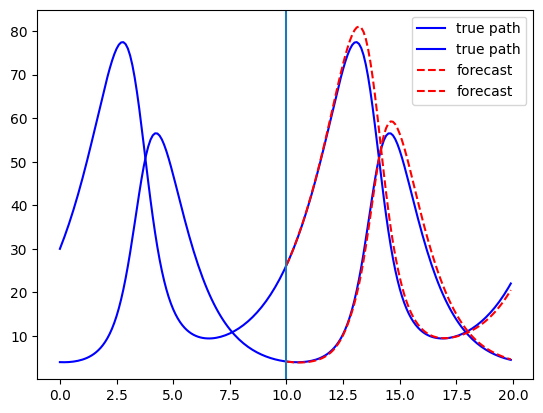

In [15]:
_, length_size, data_size = ys.shape

init = ys[0,:,:][int(length_size//2)]

ts_forecast = jnp.arange(10,20,0.1)

plt.plot(ts,true_path,label = 'true path',color = 'blue')
plt.plot(ts_forecast,model(ts_forecast,init),'--',label = 'forecast',color = 'red')
plt.axvline(x = 10)
plt.legend()

Some notes on speed:
The hyperparameters for the above example haven't really been optimised. Try experimenting with them to see how much faster you can make this example run. There's lots of things you can try tweaking:

- The size of the neural network.
- The numerical solver.
- The step size controller, including both its step size and its tolerances.
- The length of the dataset. (Do you really need to use all of a time series every time?)
- Batch size, learning rate, choice of optimiser.
- ... etc.!

Some notes on being Markov:

- This example has assumed that the problem is Markov. Essentially, that the data `ys` is a complete observation of the system, and that we're not missing any channels. Note how the result of our model is evolving in data space. This is unlike e.g. an RNN, which has hidden state, and a linear map from hidden state to data.
- If we wanted we could generalise this to the non-Markov case: inside `NeuralODE`, project the initial condition into some high-dimensional latent space, do the ODE solve there, then take a linear map to get the output. See the [Latent ODE example](../latent_ode) for an example doing this as part of a generative model; also see [Augmented Neural ODEs](https://arxiv.org/abs/1904.01681) for a short paper on it.